<a href="https://colab.research.google.com/github/V-L-A-P-P/BankruptcyPrediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries import

In [44]:
!pip install catboost
!pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.0 MB/s eta 0:00:00


# Data loading

In [33]:
# labeled dataset with financial
data = pd.read_csv('train.csv')

# Data review

In [34]:
data.shape

(733271, 112)

In [35]:
data.head()

,ID_FIRM,P1110_B,P1110_E,P1120_B,P1120_E,P1130_B,P1130_E,P1140_B,P1140_E,P1150_B,...,P2421_E,P2430_B,P2430_E,P2450_B,P2450_E,P2460_B,P2460_E,P2400_B,P2400_E,BANKR
0,1,8,7,0,0,0,0,0,0,402,...,161,0,0,0,0,0,0,1561,621,0
1,2,0,0,3318,3318,0,0,0,0,208809,...,0,0,0,0,0,0,8551,-15296,-16123,0
2,3,0,0,0,0,0,0,0,0,237,...,0,0,0,0,0,6,0,-2166,-1375,0
3,4,0,0,0,0,0,0,0,0,15428,...,-55,0,22,0,4,0,0,-3390,502,0
4,5,0,0,0,0,0,0,0,0,340249,...,-895,0,11,0,0,105,0,26131,6100,0


In [36]:
def count_zeros(row):
    return (row == 0).sum()

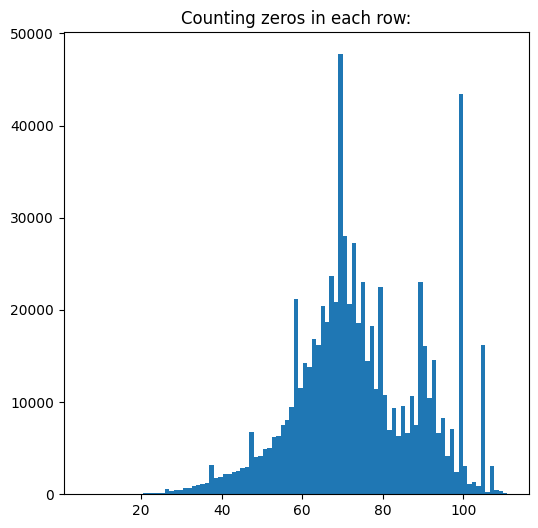

In [37]:
zero_counts = data.apply(count_zeros, axis=1)

plt.figure(figsize=(6,6))
plt.hist(zero_counts, bins=95)
plt.title("Counting zeros in each row:")
plt.show()

# Feature Engineering

In [38]:
def add_financial_features(df):
    """
    Добавляет 15 ключевых производных фичей для прогнозирования банкротства.
    Обрабатывает деление на ноль и отрицательные значения.
    Возвращает DataFrame с новыми колонками.
    """
    # Создаем копию, чтобы не изменять исходный датафрейм
    df = df.copy()

    # 1. Финансовая устойчивость
    df['equity_to_assets_ratio'] = np.where(
        df['P1700_E'] != 0,
        df['P1300_E'] / df['P1700_E'],
        np.nan
    )

    df['debt_to_capital'] = np.where(
        df['P1700_E'] != 0,
        (df['P1400_E'] + df['P1500_E']) / df['P1700_E'],
        np.nan
    )

    # 2. Ликвидность
    df['current_ratio'] = np.where(
        df['P1500_E'] != 0,
        df['P1200_E'] / df['P1500_E'],
        np.nan
    )

    df['quick_ratio'] = np.where(
        df['P1500_E'] != 0,
        (df['P1250_E'] + df['P1230_E']) / df['P1500_E'],
        np.nan
    )

    df['cash_ratio'] = np.where(
        df['P1500_E'] != 0,
        df['P1250_E'] / df['P1500_E'],
        np.nan
    )

    # 3. Рентабельность
    avg_assets = (df['P1600_B'] + df['P1600_E']) / 2
    df['roa'] = np.where(
        avg_assets != 0,
        df['P2400_E'] / avg_assets,
        np.nan
    )

    df['ros'] = np.where(
        df['P2110_E'] != 0,
        df['P2400_E'] / df['P2110_E'],
        np.nan
    )

    avg_equity = (df['P1300_B'] + df['P1300_E']) / 2
    df['roe'] = np.where(
        avg_equity != 0,
        df['P2400_E'] / avg_equity,
        np.nan
    )

    # 4. Анализ динамики
    df['revenue_growth_pct'] = np.where(
        df['P2110_B'].abs() > 0,  # Защита от деления на 0
        (df['P2110_E'] - df['P2110_B']) / df['P2110_B'].abs(),
        np.nan
    )

    df['net_debt_change'] = (df['P1410_E'] + df['P1510_E']) - (df['P1410_B'] + df['P1510_B'])

    df['cash_flow_change'] = df['P1250_E'] - df['P1250_B']

    # 5. Структурные показатели
    df['altman_z_score'] = (
        1.2 * (df['P1200_E'] / df['P1700_E'].replace(0, np.nan)) +
        1.4 * (df['P1370_E'] / df['P1700_E'].replace(0, np.nan)) +
        3.3 * (df['P2200_E'] / df['P1700_E'].replace(0, np.nan)) +
        0.6 * (df['P1300_E'] / df['P1500_E'].replace(0, np.nan)) +
        0.999 * (df['P2110_E'] / df['P1700_E'].replace(0, np.nan)))

    avg_receivables = (df['P1230_B'] + df['P1230_E']) / 2
    df['receivables_turnover'] = np.where(
        avg_receivables != 0,
        df['P2110_E'] / avg_receivables,
        np.nan
    )

    return df

In [39]:
data = add_financial_features(data)
#data = data[list(importance_df.feature)[:50] + ['ID_FIRM', 'BANKR']]
#data = data.drop(columns=['P1100_B', 'P1100_E', 'P1200_B', 'P1200_E', 'P1300_B', 'P1300_E',
#           'P1400_B', 'P1400_E', 'P1500_B', 'P1500_E'])

# Selection of best parameters with GridSeacrhCV

In [45]:
def weighted_accuracy(y_true, y_pred):
    weights = {0: 1.0, 1: len(y_true[y_true==0]) / len(y_true[y_true==1])}  # Вес = 1/пропорция класса
    sample_weights = [weights[cls] for cls in y_true]
    return accuracy_score(y_true, y_pred, sample_weight=sample_weights)

X = data.drop(['ID_FIRM', 'BANKR'], axis=1)
y = data.BANKR

# Загрузка данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(verbose=100,
                           eval_metric='BalancedAccuracy',
                           depth=5,
                           learning_rate=0.01,
                           l2_leaf_reg=5,
                           min_data_in_leaf=10)

param_grid = {
    #'depth': [4, 5, 6],
    #'learning_rate': [0.01, 0.05],
    'iterations': [1000, 2000],
    'scale_pos_weight': [238, 300],
    #'l2_leaf_reg': [3, 5],
    #'min_data_in_leaf': [5, 10]
}

grid_search = GridSearchCV(estimator=model,
                         param_grid=param_grid,
                         cv=3,
                         scoring=make_scorer(weighted_accuracy),
                         n_jobs=-1,
                         refit=True)

grid_search.fit(X_train, y_train,
               verbose=100,
               early_stopping_rounds=50)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший score:", grid_search.best_score_)


KeyboardInterrupt: 

# Selection of best parameters with Optuna (with finding correct limit for zeros)

In [41]:
zero_counts = data.apply(count_zeros, axis=1)

X = data.drop(["ID_FIRM","BANKR"], axis=1)
y = data["BANKR"]

data.head()

,ID_FIRM,P1110_B,P1110_E,P1120_B,P1120_E,P1130_B,P1130_E,P1140_B,P1140_E,P1150_B,...,quick_ratio,cash_ratio,roa,ros,roe,revenue_growth_pct,net_debt_change,cash_flow_change,altman_z_score,receivables_turnover
0,1,8,7,0,0,0,0,0,0,402,...,773.600000,338.800000,0.018794,0.042590,0.018854,-0.008230,0.0,-423,3751.822845,5.015824
1,2,0,0,3318,3318,0,0,0,0,208809,...,0.015972,0.000496,-0.010284,-0.634614,0.012836,-0.148878,0.0,610,-1.000058,0.433835
2,3,0,0,0,0,0,0,0,0,237,...,0.553521,0.000000,-0.004554,NaN,0.223450,NaN,1447.0,0,1.127367,0.000000
3,4,0,0,0,0,0,0,0,0,15428,...,1.609435,1.349424,0.028035,0.079632,0.030861,-0.018680,0.0,941,7.034204,14.711785
4,5,0,0,0,0,0,0,0,0,340249,...,0.247706,0.011042,0.004033,0.044474,0.007678,0.043955,-40787.0,-1285,1.748645,0.815910


In [42]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight="balanced", classes=np.unique(data.BANKR), y=data.BANKR)
weights

array([  0.50214342, 117.13594249])

In [ ]:
class_weights = dict(zip(np.unique(data.BANKR), weights))


def objective(trial):
    limit = trial.suggest_int("limit_zero", 50, 90)

    mask = zero_counts <= limit
    X_filtered = X[mask]
    y_filtered = y[mask]

    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=0.2, random_state=42
    )

    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])

    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128, 256]),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'bootstrap_type': bootstrap_type,
        'class_weights': class_weights,
        'eval_metric': "F1",
        'verbose': False,
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'rsm': trial.suggest_float('rsm', 0.5, 1.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 100)
    }

    # Добавляем bagging_temperature только для Bayesian
    if bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 1)
    else:
        # Альтернативные параметры для других типов бутстрепа
        params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)

    model = CatBoostClassifier(**params)

    model.fit(
    X_train, y_train,
    early_stopping_rounds=100,  # Ранняя остановка, если нет улучшений
)

    # Получаем предсказания для тестового набора
    y_pred = model.predict(X_test)

    # Вычисляем weighted_accuracy
    #f1_weighted = f1_score(y_test, y_pred, average='weighted')
    acc_weighted = weighted_accuracy(y_test, y_pred, weights)

    return acc_weighted  # Возвращаем weighted acc для оптимизации

# Настройка Optuna
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Запуск оптимизации
study.optimize(objective, n_trials=70)

# Вывод результатов
print("\nЛучшие параметры:", study.best_params)
print("Лучший weighted_accuracy:", study.best_value)
print("\nСтатистика trials:")
print(study.trials_dataframe().sort_values('value', ascending=False).head())

# Визуализация
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

# Model fitting

In [ ]:
X = data.drop(['ID_FIRM', 'BANKR'], axis=1)
y = data.BANKR

# Загрузка данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight="balanced", classes=np.unique(data.BANKR), y=data.BANKR)

model = CatBoostClassifier(
    iterations=2000,       # Количество итераций (деревьев)
    learning_rate=0.01,    # Скорость обучения
    depth=5,              # Глубина деревьев
    eval_metric='BalancedAccuracy',     # Метрика для валидации
    verbose=100,          # Вывод логов каждые 100 итераций
    scale_pos_weight=300,
    #l2_leaf_reg=3,
    #min_data_in_leaf=5,

    min_data_in_leaf=5,
    grow_policy='Lossguide',
    l2_leaf_reg=10,
    random_strength=0.5,    # Рандомизация для устойчивости к шуму
    bootstrap_type='Bayesian',  # Байесовская бустировка
)

model.fit(
    X_train, y_train,
    early_stopping_rounds=50,  # Ранняя остановка, если нет улучшений
)

# Score estimating

In [ ]:
def weighted_accuracy(y_true, y_pred, weights=None):
    """
    Вычисляет взвешенную accuracy (учитывает дисбаланс классов).
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if weights is None:
        # Автоматический расчет весов (обратно пропорционально количеству объектов)
        classes, counts = np.unique(y_true, return_counts=True)
        weights = {c: len(y_true) / (len(classes) * count) for c, count in zip(classes, counts)}

    # Расчет весов для каждого объекта
    sample_weights = np.array([weights[c] for c in y_true])

    # Взвешенная accuracy
    correct_predictions = (y_true == y_pred).astype(int)
    weighted_acc = np.sum(correct_predictions * sample_weights) / np.sum(sample_weights)

    return weighted_acc

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("Weighted Accuracy:", weighted_accuracy(y_test, y_pred, weights=weights))
print("F1-score (weighted):", f1_score(y_test, y_pred, average="weighted"))